In [28]:
import tensorflow as tf 
from basemodel import LeNet, LeNetEncoder, Discriminator
from sklearn.metrics import accuracy_score
from dataloader import DataLoader

## Lenet Model For Source 

In [2]:
model = LeNet()

In [8]:
sample_input = tf.random.uniform(shape=(10, 28, 28, 1))
y = model(sample_input)

In [9]:
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LeNetEncoder (LeNetEncoder)  multiple                 926070    
                                                                 
 LeNetClassifier (LeNetClass  multiple                 5010      
 ifier)                                                          
                                                                 
Total params: 931,080
Trainable params: 931,080
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.encoder.summary()

Model: "LeNetEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  520       
                                                                 
 conv2d_1 (Conv2D)           multiple                  25050     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dense (Dense)               multiple                  900500    
                                                                 
 dropout (Dropout)           multiple                 

In [11]:
model.classifier.summary()

Model: "LeNetClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  5010      
                                                                 
Total params: 5,010
Trainable params: 5,010
Non-trainable params: 0
_________________________________________________________________


## Prepare Datasets (source)

DataLoder module loads the MNIST and USPS datasets and splits them into train test

In [12]:
loader = DataLoader("mnist")

Loading dataset mnist


In [13]:
(x_train, y_train) = loader.getData('train')
(x_test, y_test) = loader.getData('test')

Creating Data Iterator for mini-batch training loop

In [15]:
BATCH_SIZE = 64

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

## Train on source with cross-entopy loss

In [19]:
loss_metric = tf.keras.metrics.Mean()
m = tf.keras.metrics.Accuracy()

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
ce_loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

In [21]:
epochs = 10    

In [22]:
# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch) in enumerate(train_dataset):
        #x_batch_train = tf.expand_dims(x_batch_train, axis=3)
        with tf.GradientTape() as tape:
            pred = model(x_batch_train)
                
            loss = tf.reduce_mean(ce_loss_fn(y_batch, pred))
            m.update_state(tf.argmax(y_batch, 1),tf.argmax(pred, 1))
    
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
        loss_metric(loss)
    
        if step % 100 == 0:
            print("step %d: mean loss = %.4f acc=%.4f" % (step, loss_metric.result(),  m.result()))
        
    val_loss_metric = tf.keras.metrics.Mean()
    val_acc = tf.keras.metrics.Accuracy()
        
    for i, (x_batch_test, y_batch_test) in enumerate(test_dataset):
        #x_batch_test = tf.expand_dims(x_batch_test, axis=3)
        pred_val = model(x_batch_test)                
        val_loss = tf.reduce_mean(ce_loss_fn(y_batch_test, pred_val))
        val_loss_metric(val_loss)
        val_acc.update_state(tf.argmax(y_batch_test, 1),tf.argmax(pred_val, 1))
    print("Validation: Mean loss = %.4f acc=%.4f" % (val_loss_metric.result(),  val_acc.result()))                    
    

Start of epoch 0
step 0: mean loss = 2.4691 acc=0.1406
step 100: mean loss = 0.3867 acc=0.8841
step 200: mean loss = 0.2550 acc=0.9240
step 300: mean loss = 0.1995 acc=0.9408
step 400: mean loss = 0.1660 acc=0.9506
step 500: mean loss = 0.1474 acc=0.9560
step 600: mean loss = 0.1346 acc=0.9597
step 700: mean loss = 0.1245 acc=0.9630
step 800: mean loss = 0.1164 acc=0.9651
step 900: mean loss = 0.1087 acc=0.9673
Validation: Mean loss = 0.0420 acc=0.9868
Start of epoch 1
step 0: mean loss = 0.1060 acc=0.9681
step 100: mean loss = 0.1006 acc=0.9697


KeyboardInterrupt: 

In [23]:
#Save the model
#model.save_weights('./models/mnist_lenet')

## Training on Target Domain (assuming NO labels available)

Here labels will be used only for evaluation of results NOT for training

In [72]:
usps_loader = DataLoader("usps")
X_tr, y_tr = usps_loader.getData('train')

usps_loader = DataLoader("usps")
X_tr_test, y_tr_test = usps_loader.getData('test')

mnist_loader = DataLoader("mnist")
X_sr, y_sr = mnist_loader.getData("train")

Loading dataset usps
Loading dataset usps
Loading dataset mnist


Creating Dataset Iterators for mini-batch training loop on target 

In [52]:
BATCH_SIZE_TR = 50

In [53]:
tgt_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
tgt_dataset = tgt_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE_TR)

src_dataset = tf.data.Dataset.from_tensor_slices((X_sr, y_sr))
src_dataset = src_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE_TR)

## Load model 

In [44]:
targetModel = LeNet()

In [45]:
sample_input = tf.random.uniform(shape=(10, 28, 28, 1))
y = targetModel(sample_input)

In [46]:
print(targetModel.encoder.layers[0].weights[0][0])

tf.Tensor(
[[[ 0.25764418 -0.4344312  -0.23487836 -0.6368644  -0.09831333
   -0.30021572 -0.19820322 -0.5474057  -0.01948217  0.32862338
   -0.23803072  0.54441565 -0.37289748  0.23799616 -0.17097431
    0.01183602 -0.04524669 -0.14436963 -0.06269884  0.40728557]]

 [[ 0.05310753  0.47370708  0.02922638  0.0151893  -0.21619004
    0.25074014  0.30931202  0.09896408 -0.03815591 -0.19670078
   -0.38282812 -0.03994374 -0.08832493 -0.36956742  0.55703664
    0.57569104 -0.34877637  0.47169927  0.03139093  0.2773745 ]]

 [[ 0.33803526  0.5445516   0.27999     0.3480448   0.16070475
   -0.13176227  0.05839105 -0.07514603  0.04485394 -0.03488219
   -0.24620245 -0.22203222  0.2836577  -0.04203669 -0.4803562
    0.03521154 -0.1910748   0.3517557  -0.30216247  0.15887049]]

 [[ 0.3856084   0.18080075  0.02889966 -0.11011384  0.15608707
    0.31399626 -0.45553252  0.1196666  -0.01927428 -0.30070567
    0.35134557 -0.24990977  0.19830438 -0.2573115   0.11254888
    0.41554958 -0.4677888  -0.112954

In [75]:
checkpoint_path = ".\\models\\mnist_lenet"
# init weights of target encoder with those of source encoder
targetModel.load_weights(checkpoint_path)  

Check if new weights loaded properly

In [76]:
print(targetModel.encoder.layers[0].weights[0][0])

tf.Tensor(
[[[ 0.07447814 -0.00880726 -0.2455518  -0.14313318 -0.206044
    0.01054084 -0.45289755  0.39708784 -0.06829995  0.41723385
    0.07748751 -0.42984262 -0.03139526 -0.11600942 -0.0976113
    0.10573574 -0.37824258  0.02161951  0.5805371  -0.07381678]]

 [[-0.03983057  0.1241329   0.2847217  -0.24746835 -0.27586755
   -0.05461131 -0.09643356 -0.09678437  0.19254015 -0.3950874
   -0.20059995 -0.64347035 -0.6227867  -0.05109233  0.00334542
    0.02967518 -0.3179615   0.0135891   0.24304534 -0.19977543]]

 [[-0.0078422   0.06580239 -0.3811191  -0.18182144  0.36455932
   -0.0654147   0.314523    0.3750171   0.10549959 -0.09135032
   -0.35417858 -0.27474433  0.2563004  -0.37529317 -0.10289144
    0.42643112 -0.34611034  0.28337616 -0.27924997 -0.3395373 ]]

 [[ 0.2836141  -0.49414167 -0.13555625  0.09657162  0.15958536
   -0.12617801  0.3260055  -0.02024609  0.6486877   0.13205835
   -0.15898919 -0.12551579 -0.1586223   0.09797388 -0.5715533
   -0.39811888  0.03213071 -0.00512786 -

### Check Accuracy of Target Domain without any further training

In [77]:
ypred = targetModel(X_tr)        
predClass = tf.argmax(ypred, axis=1)
print(accuracy_score(y_tr, predClass))

0.8302016184336853


In [78]:
ypred = targetModel(X_tr_test)        
predClass = tf.argmax(ypred, axis=1)
print(accuracy_score(y_tr_test, predClass))

0.8086696562032885


# Domain Adaptation for Target Domain

In [59]:
targetEncoder = targetModel.encoder

In [60]:
targetEncoder_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
cross_entropy = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

## Computing Maximum Mean Discrepancy (MMD)

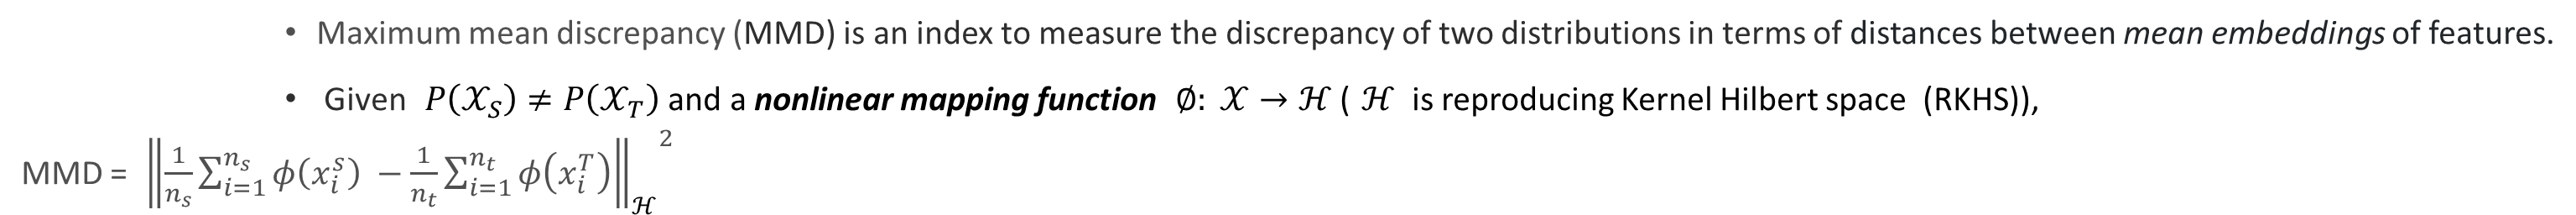

Approximating the non-linear feature map above with a neural net below is out MMD or MDA implementation

In [55]:
def mdaLoss(sourceEncoding, targetEncoding):
    diff = tf.reduce_mean(sourceEncoding, axis=0) - tf.reduce_mean(targetEncoding, axis=0)    
    return tf.reduce_sum(tf.math.square(diff))

# Training Loop For Joint Source and Target Taining

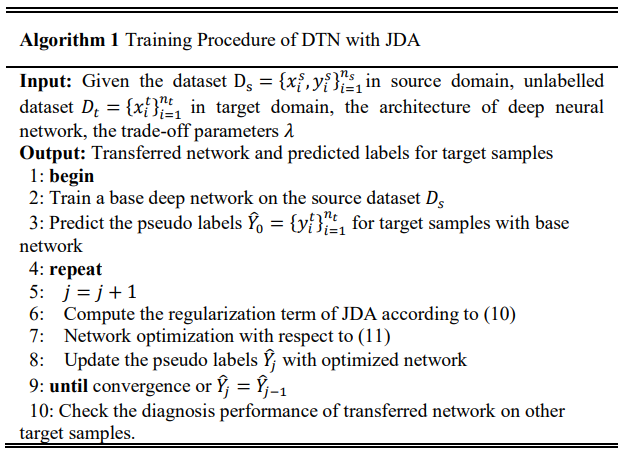
Source: https://arxiv.org/ftp/arxiv/papers/1804/1804.07265.pdf

In [56]:
num_epochs = 100
num_classes = 10
lam = 0.0001

In [57]:
loss_metric = tf.keras.metrics.Mean()
target_acc = tf.keras.metrics.Accuracy()
source_acc  = tf.keras.metrics.Accuracy()

In [61]:
for epoch in range(num_epochs):
    
    loss_metric.reset_states()
    target_acc.reset_states()
    source_acc.reset_states()
    
    print("Epoch {}".format(epoch))
    src_dataset = tf.data.Dataset.from_tensor_slices((X_sr, y_sr))
    src_dataset = src_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE_TR)

    data_zip = enumerate(zip(src_dataset, tgt_dataset))
    
    for step, ((images_src, y_src), (images_tgt, y_tgt)) in data_zip:
        #print(step, images_src.shape, images_tgt.shape)
        if images_tgt.shape[0]<50:
            break
        with tf.GradientTape() as tape:
            sourceEncoding = targetEncoder(images_src)
            targetEncoding = targetEncoder(images_tgt)
            
            mda = mdaLoss(sourceEncoding, targetEncoding)
                
            pseudo_y_tar = targetModel(images_tgt)
            pseudo_y_tar = tf.cast(tf.argmax(pseudo_y_tar, axis = 1), tf.int32)
                
            pred = targetModel(images_src)
            #Compute usual cross entropy loss on source
            loss = tf.reduce_mean(cross_entropy(y_src, pred))
            
            y_src_argmax = tf.cast(tf.argmax(y_src, axis = 1), tf.int32)
            source_acc.update_state(y_src_argmax,tf.argmax(pred, 1))
            
            jda = mda
            
            for c in range(num_classes):
                x_batch_train_src_c = tf.squeeze(tf.gather(images_src,tf.where(y_src_argmax == c)), axis = 1)                    
                x_batch_train_tar_c = tf.squeeze(tf.gather(images_tgt,tf.where(pseudo_y_tar == c)), axis= 1)
                if  x_batch_train_src_c.shape[0] > 0 and  x_batch_train_tar_c.shape[0]>0:
                    sourceEncoding_c = targetEncoder(x_batch_train_src_c)
                    targetEncoding_c = targetEncoder(x_batch_train_tar_c)
                    jda += mdaLoss(sourceEncoding_c, targetEncoding_c)
                    #print(c, x_batch_train_src_c.shape, x_batch_train_tar_c.shape)
            loss += lam * jda
            
            last_layer_weights = targetModel.encoder.fc1.trainable_weights + targetModel.classifier.fc2.trainable_weights
        grads = tape.gradient(loss, last_layer_weights)
        targetEncoder_optimizer.apply_gradients(zip(grads, last_layer_weights))
        loss_metric(loss)
        
        if step % 20 == 0:
            print("epoch %d step %d :Mean JDA Loss = %.4f" % (epoch, 
                                                                             step,
                                                              loss_metric.result()))
                
            for i, (x_batch_test, y_batch_test) in enumerate(tgt_dataset):
                #test_predictions
                pred = targetModel(x_batch_test)
                predClass = tf.argmax(pred, axis=1)                    
                target_acc.update_state(y_batch_test,predClass)
            print("Target Acc:%.4f" %(target_acc.result()))
            
    print("Epoch {} Target Acc{} Source Acc{}".format(epoch, target_acc.result(), source_acc.result()))


Epoch 0
epoch 0 step 0 :Mean JDA Loss = 0.3674
Target Acc:0.8302
epoch 0 step 20 :Mean JDA Loss = 0.3440
Target Acc:0.8318
epoch 0 step 40 :Mean JDA Loss = 0.3323
Target Acc:0.8334
epoch 0 step 60 :Mean JDA Loss = 0.3168
Target Acc:0.8350
epoch 0 step 80 :Mean JDA Loss = 0.3008
Target Acc:0.8364
epoch 0 step 100 :Mean JDA Loss = 0.2843
Target Acc:0.8378
epoch 0 step 120 :Mean JDA Loss = 0.2675
Target Acc:0.8389
epoch 0 step 140 :Mean JDA Loss = 0.2533
Target Acc:0.8400
Epoch 0 Target Acc0.8400082588195801 Source Acc0.9986206889152527
Epoch 1
epoch 1 step 0 :Mean JDA Loss = 0.1641
Target Acc:0.8483
epoch 1 step 20 :Mean JDA Loss = 0.1633
Target Acc:0.8496
epoch 1 step 40 :Mean JDA Loss = 0.1615
Target Acc:0.8503
epoch 1 step 60 :Mean JDA Loss = 0.1553
Target Acc:0.8509
epoch 1 step 80 :Mean JDA Loss = 0.1480
Target Acc:0.8514
epoch 1 step 100 :Mean JDA Loss = 0.1410
Target Acc:0.8518
epoch 1 step 120 :Mean JDA Loss = 0.1372
Target Acc:0.8522
epoch 1 step 140 :Mean JDA Loss = 0.1312
Targ

KeyboardInterrupt: 

## Results on Target Domain

In [62]:
targetModel = LeNet()

In [67]:
sample_input = tf.random.uniform(shape=(10, 28, 28, 1))
y = targetModel(sample_input)

In [68]:
target_checkpoint_path = ".\\models\\jda_usps\\usps_cnn"
# init weights of target encoder with those of source encoder
targetModel.load_weights(target_checkpoint_path)  

In [71]:
ypred = targetModel(X_tr)        
predClass = tf.argmax(ypred, axis=1)
print(accuracy_score(y_tr, predClass))

0.9380057605266767


In [73]:
ypred = targetModel(X_tr_test)        
predClass = tf.argmax(ypred, axis=1)
print(accuracy_score(y_tr_test, predClass))

0.9142999501743896
